In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plorts
from common import *
import matplotlib
plt.style.use(['plorts', 'plorts-print', 'plorts-neon', './buffer-workshop.mplstyle'])
width = 7.141
matplotlib.rcParams['figure.figsize'] = (width, width*1/3)

In [7]:
df = pd.read_sql("""
select * from traces
inner join experiments on experiments.id = traces.experiment_id
where note in ('postcard', 'postcard-ecn', 'postcard-reno')
and algorithm = 'reno'
and action = 'drop'
and max_queue_depth_cells = 18675
""", con)
df.head()

,index,data_len,dest,dport,mark,rcv_wnd,snd_cwnd,snd_nxt,snd_una,snd_wnd,...,max_queue_depth_cells,max_queue_depth_packets,mtu_bytes,num_flows,receiver_delay,note,run_at,pacing,pacing_factor,experimenter
0,None,0,69.53.245.200:50385,50385,0,65536,50,2520414185,2520414029,131008,...,18675,166.0,9000,128,1ms,postcard,2020-05-07 19:01:59.339840,False,1.0,bspang
1,None,0,69.53.245.200:50385,50385,0,65536,50,2520414185,2520414089,131008,...,18675,166.0,9000,128,1ms,postcard,2020-05-07 19:01:59.339840,False,1.0,bspang
2,None,0,69.53.245.200:50385,50385,0,65536,50,2520414185,2520414125,131008,...,18675,166.0,9000,128,1ms,postcard,2020-05-07 19:01:59.339840,False,1.0,bspang
3,None,0,69.53.245.200:50385,50385,0,65536,50,2520414229,2520414185,131008,...,18675,166.0,9000,128,1ms,postcard,2020-05-07 19:01:59.339840,False,1.0,bspang
4,None,0,69.53.245.200:50385,50385,0,65536,50,2520414305,2520414229,131008,...,18675,166.0,9000,128,1ms,postcard,2020-05-07 19:01:59.339840,False,1.0,bspang


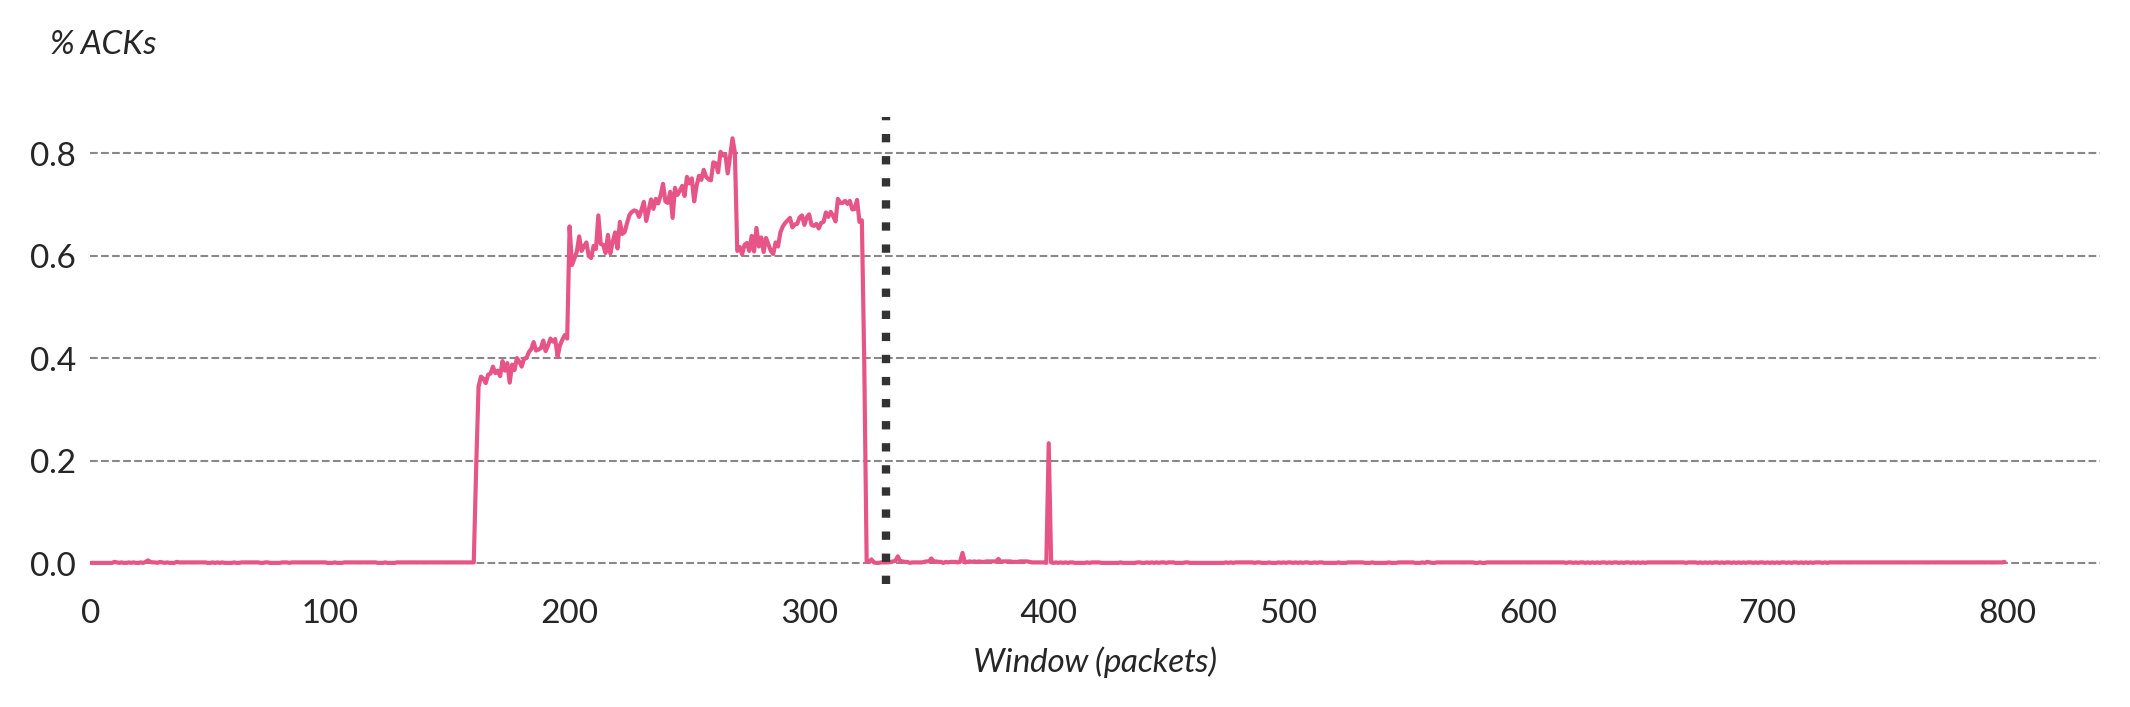

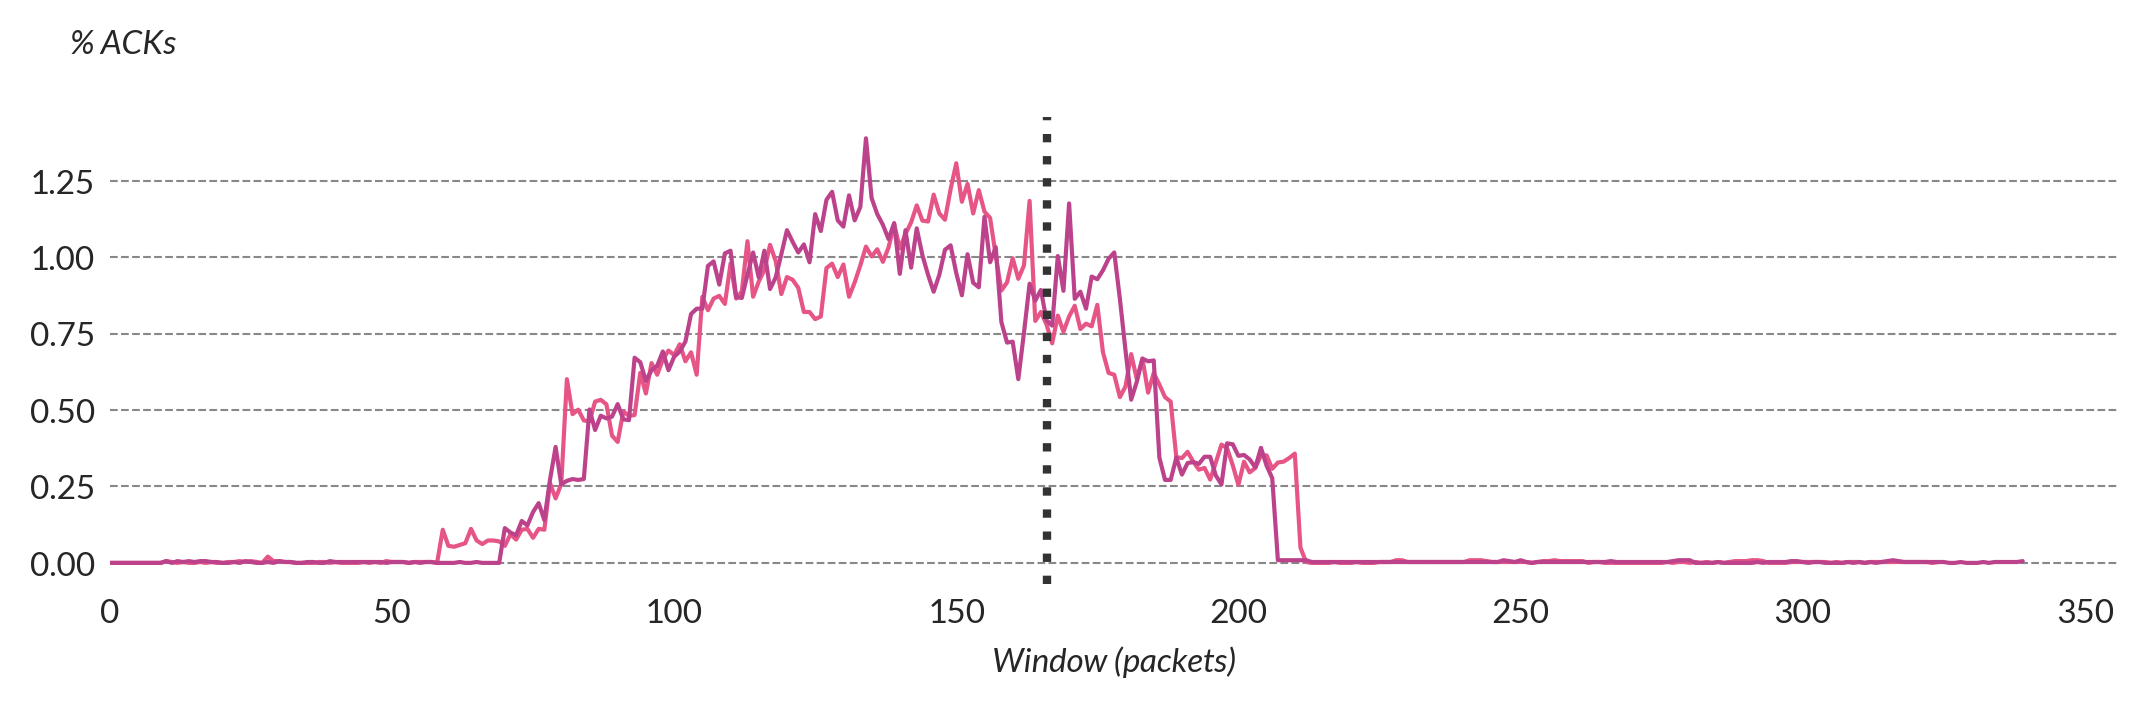

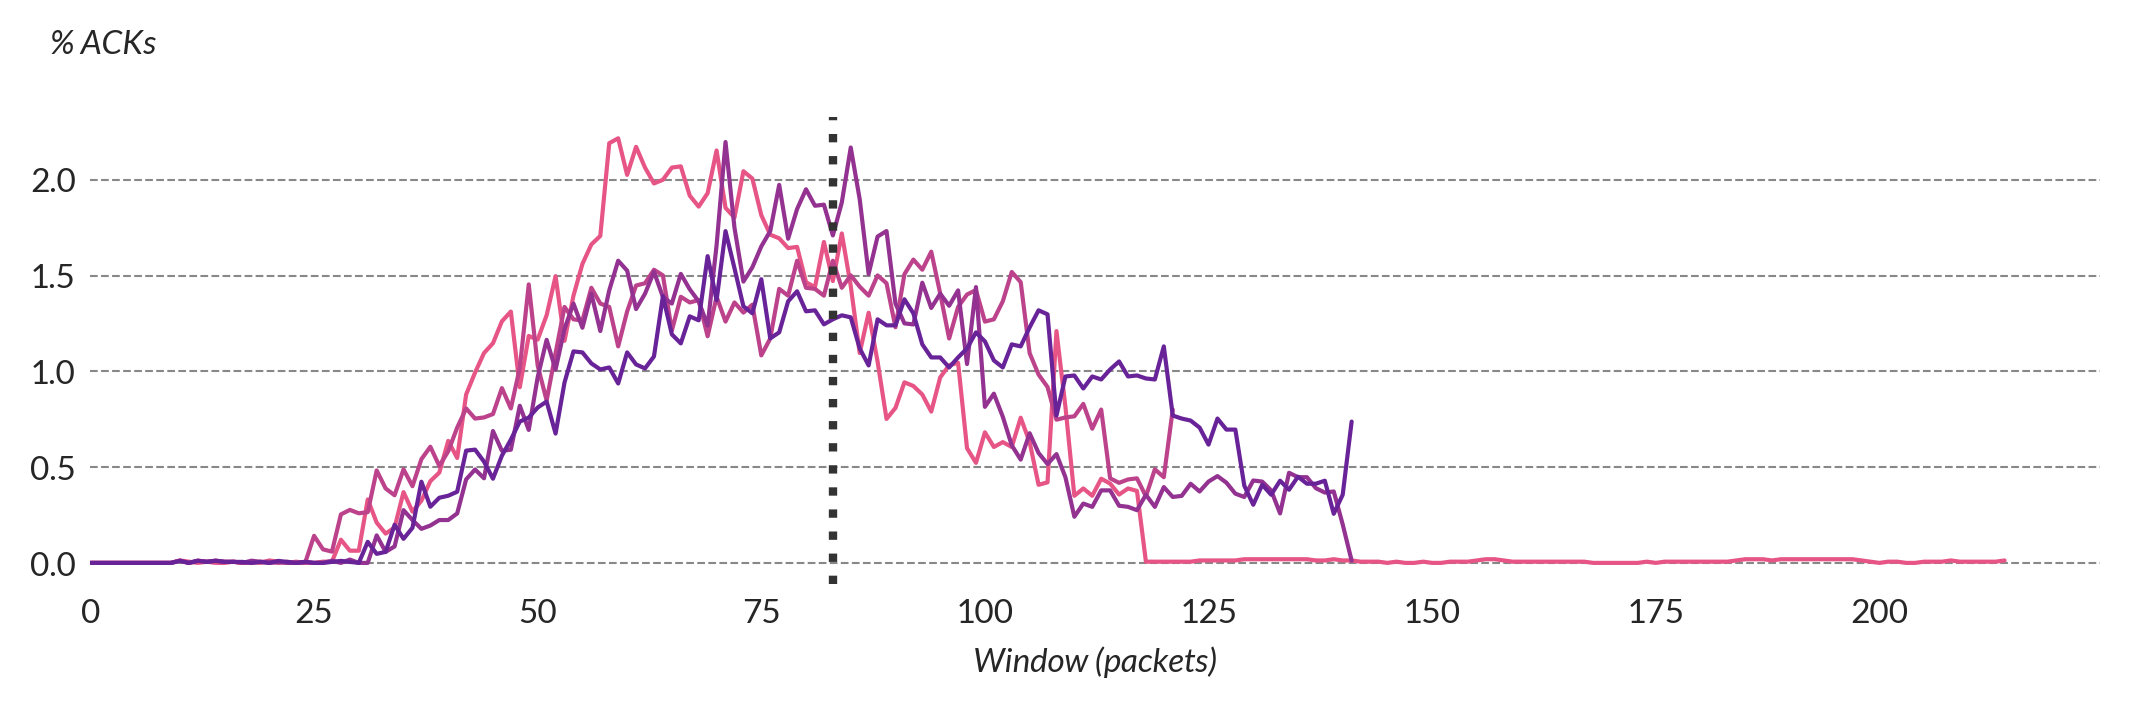

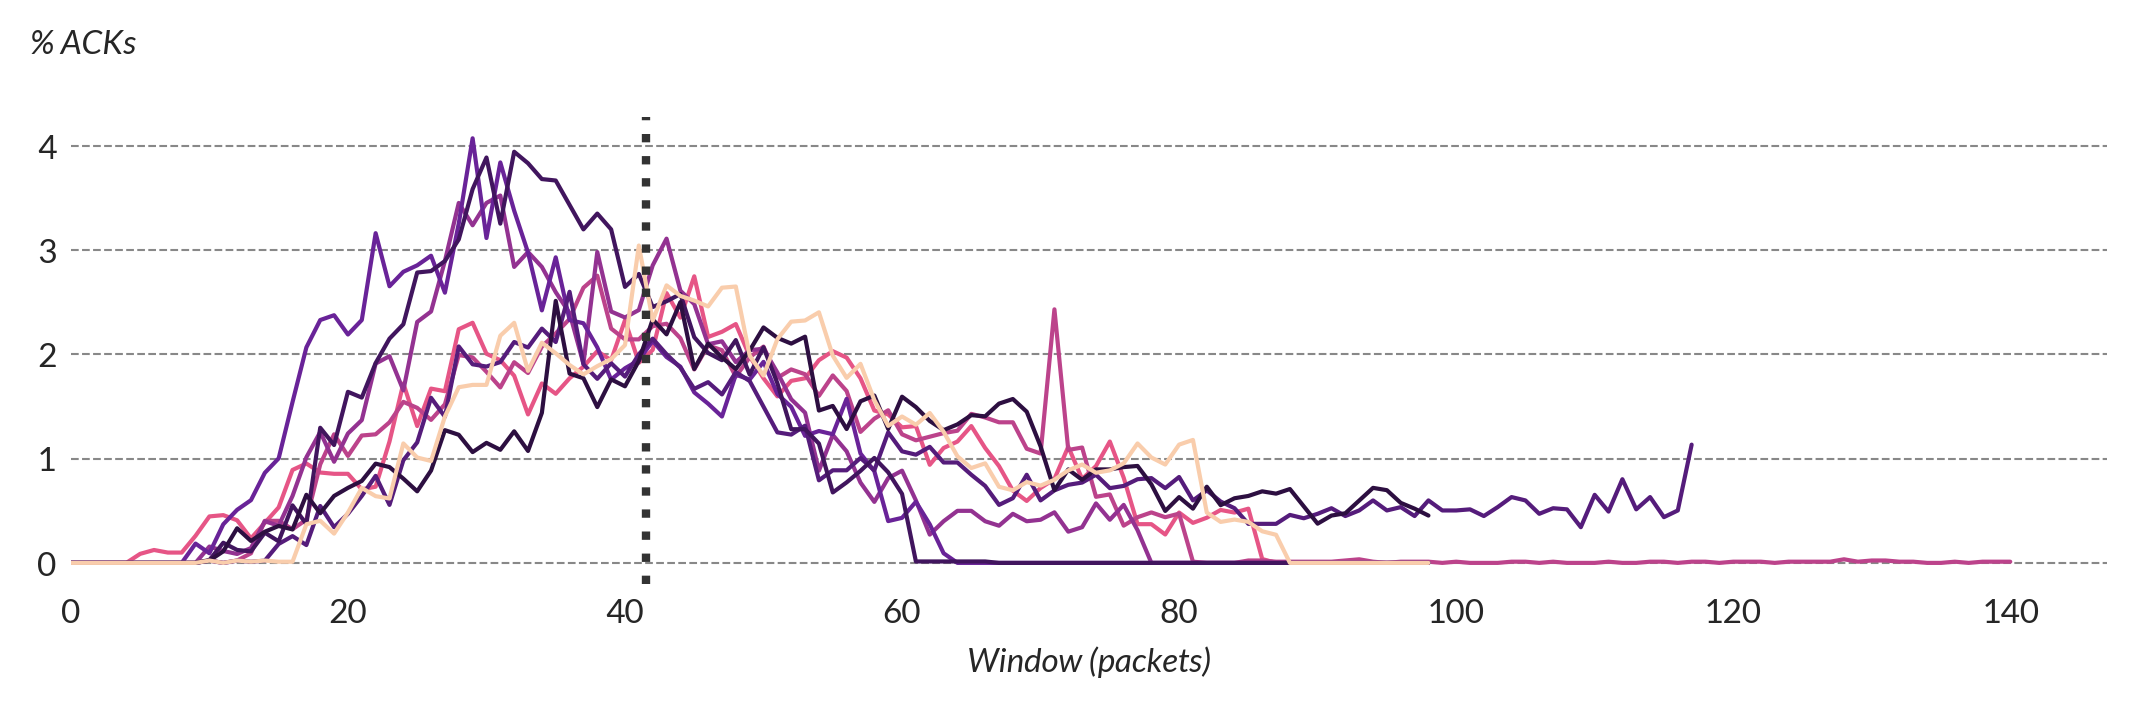

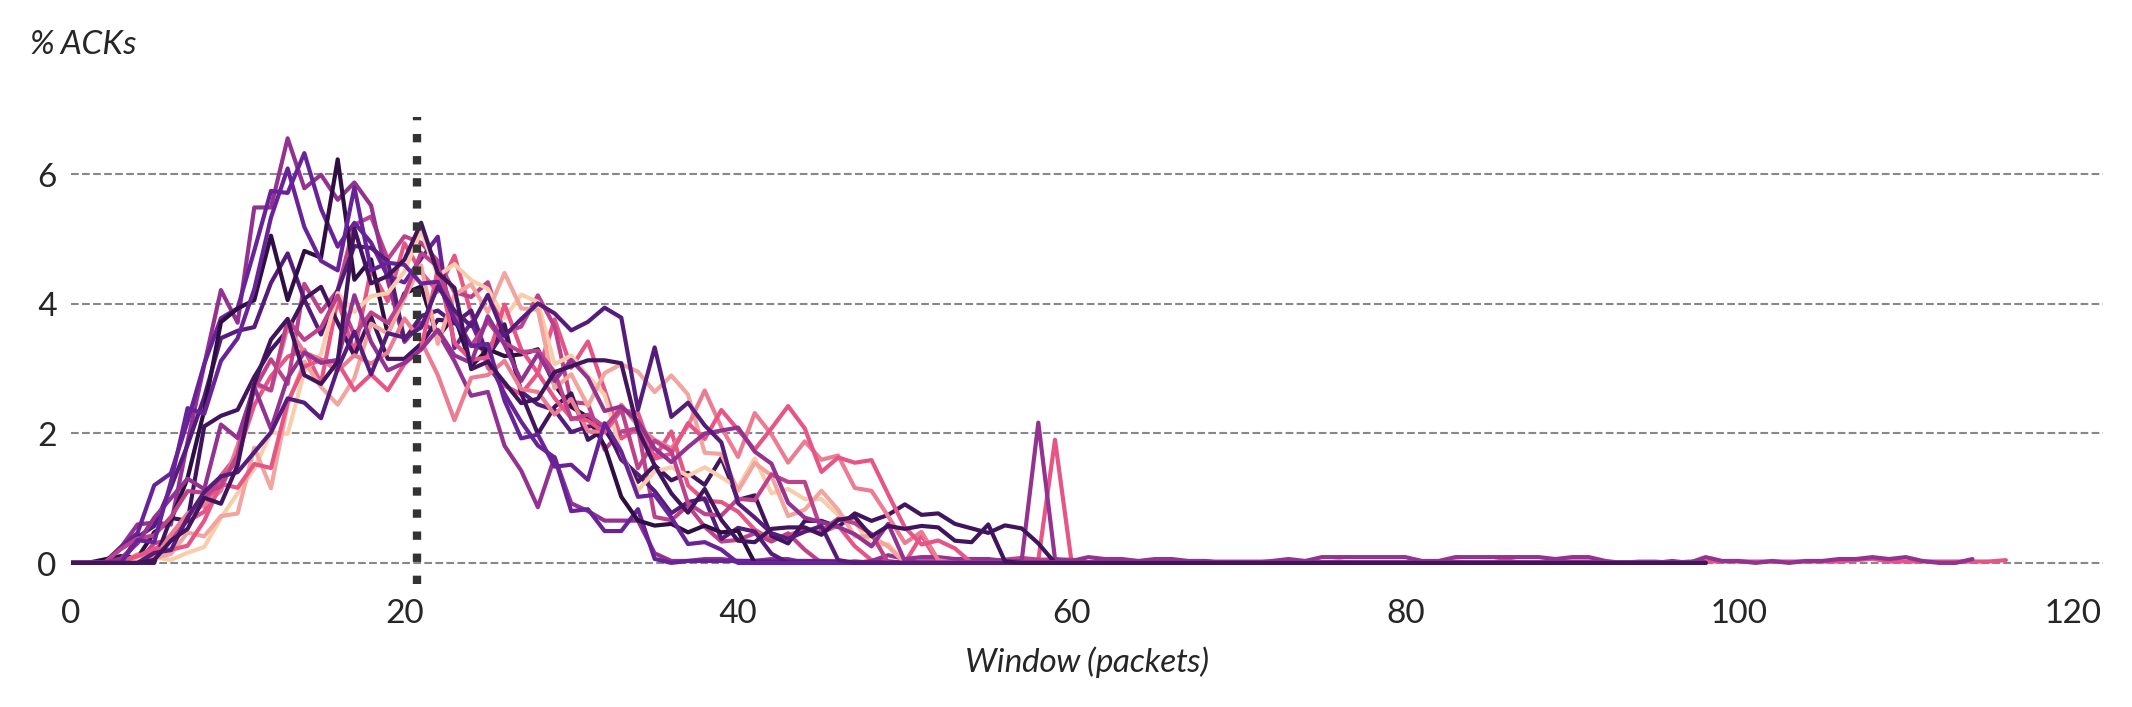

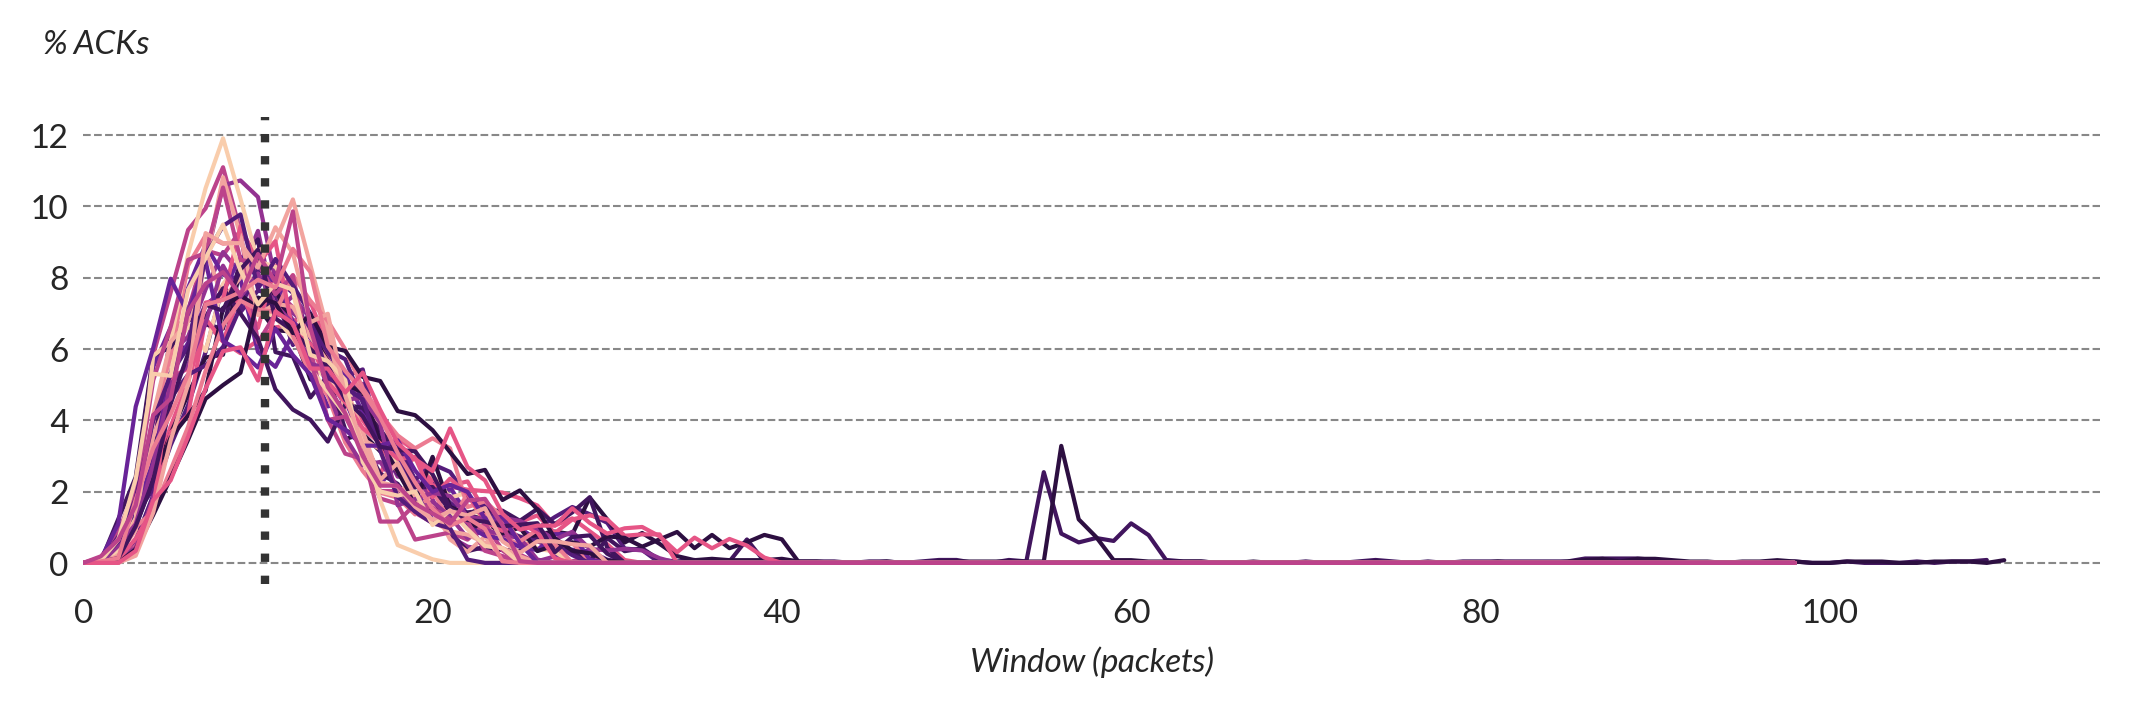

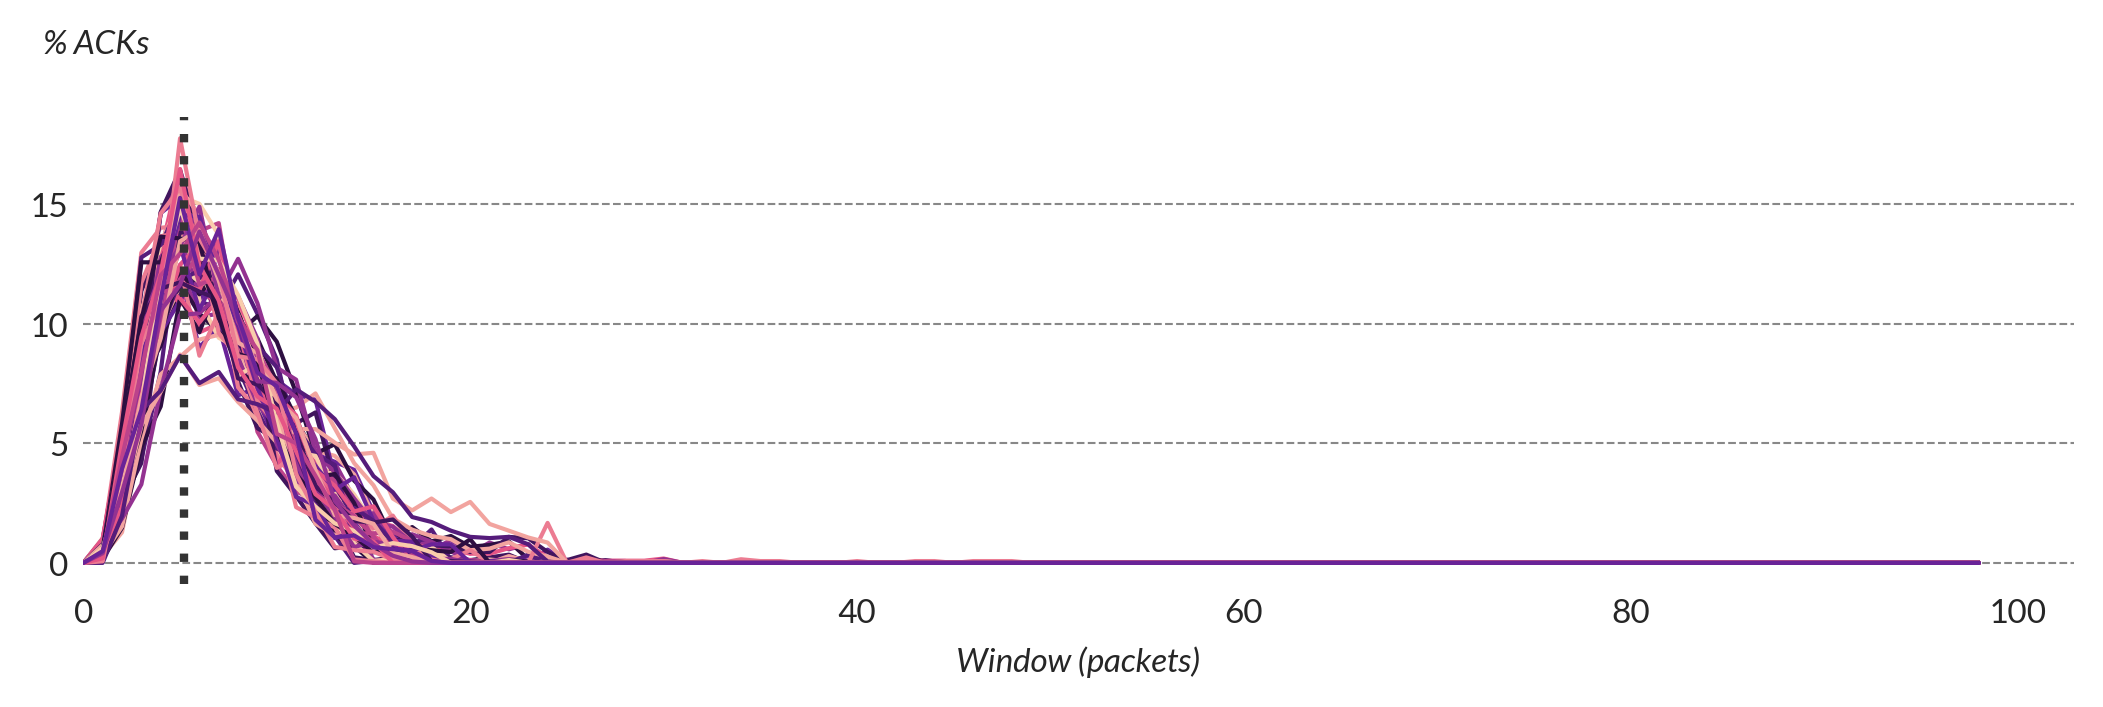

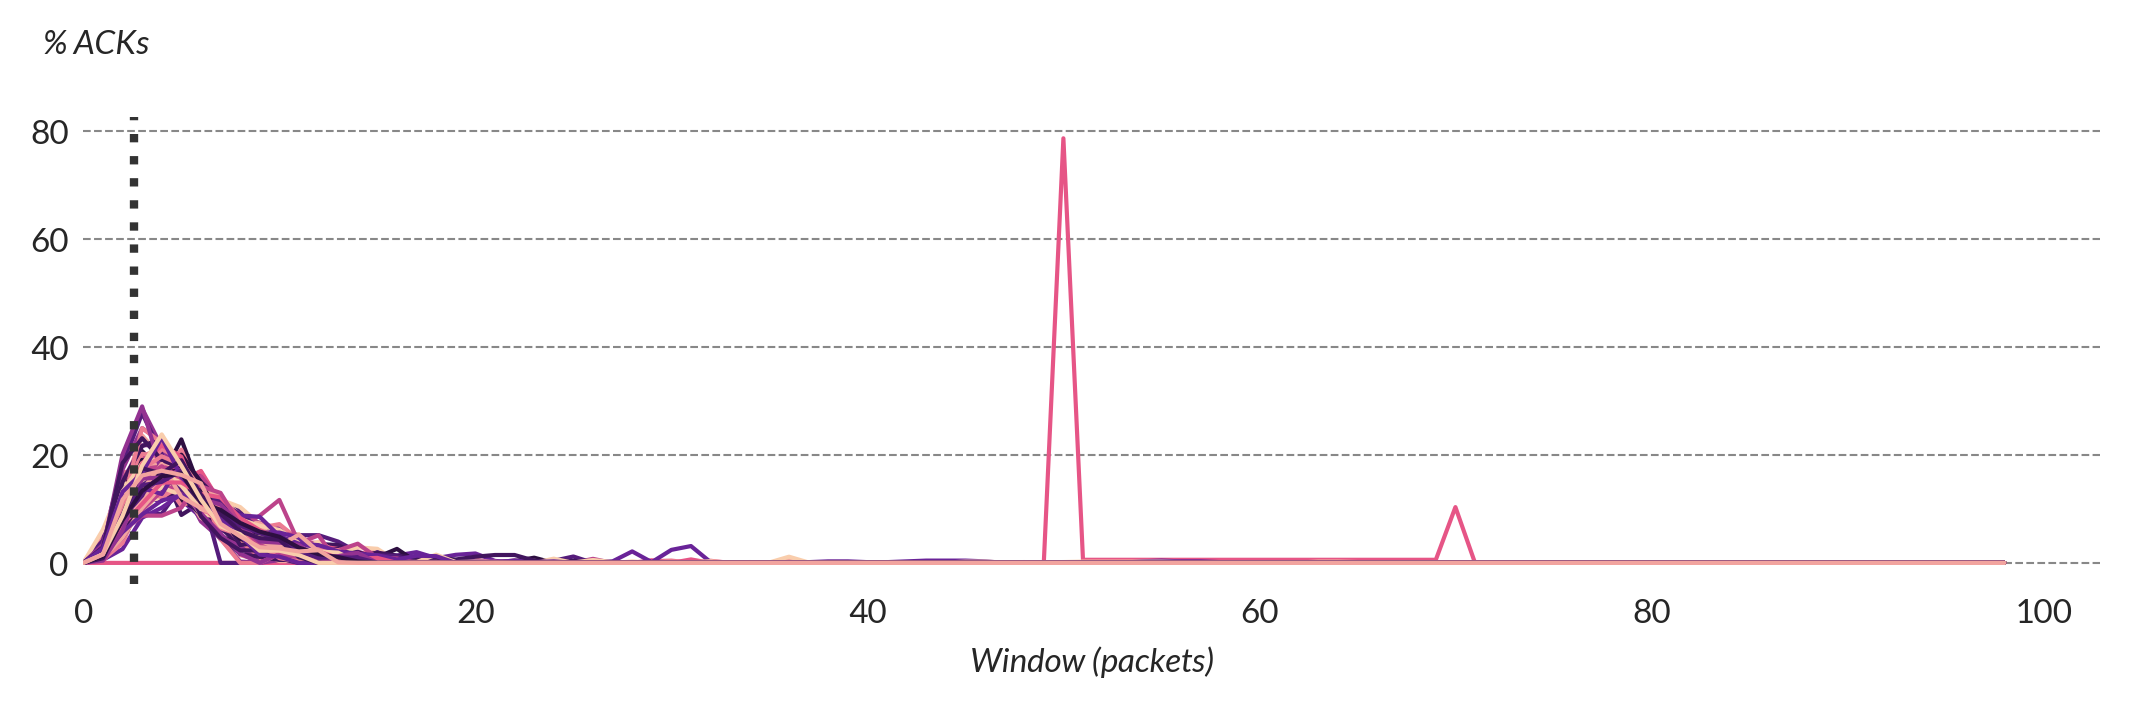

In [9]:
bdp = 166
B = df.iloc[0].max_queue_depth_packets

distribution_stats = []

for n, nfdf in df.sort_values('num_flows').groupby('num_flows'):
    plt.figure(figsize=(width, 1/3*width))
    
    cwnds = []
    for flow,fdf in nfdf.groupby(['sport', 'dport']):
        if len(fdf) < 100: continue

        max_cwnd = max(fdf.snd_cwnd.max(), 100)
        ys,xs = np.histogram(fdf.snd_cwnd, bins=np.arange(0,max_cwnd,1))
        ys = np.divide(ys, sum(ys))*100

        plt.plot(xs[:-1], ys, label=flow, linewidth=1)
        cwnds.extend(fdf.snd_cwnd)
        
    cwnds = np.array(cwnds)
    for quantile in [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]:
        distribution_stats.append([n, quantile, np.quantile(cwnds, quantile)])
    mean = (bdp + B)/n
    distribution_stats.append([n, 0, np.min(cwnds)])
    distribution_stats.append([n, 100, np.max(cwnds)])
    distribution_stats.append([n, "iqr", np.quantile(cwnds, 0.75) - np.quantile(cwnds, 0.25)])
    distribution_stats.append([n, "normalized-99", (np.quantile(cwnds, 0.99))/mean])
    distribution_stats.append([n, "normalized-01", (np.quantile(cwnds, 0.01))/mean])


    plt.axvline(x=(bdp + B)/n, linestyle=":", color='#333333')
#    plt.text((bdp + B)/n+1, 6, "Fair share", fontweight='bold', color='#333333')

    plt.xlabel("Window (packets)")
    plt.ylabel("% ACKs")
    plt.axis(xmin=0)
    plorts.style_axis()

    plt.savefig(f"../figures/fairness_reno_drop_{n}_{bdp}.png")